In [1]:
import sqlite3
import pandas as pd
from time import time
from sklearn.preprocessing import LabelEncoder
from sklearn import tree

In [2]:
lb_make = LabelEncoder()

In [3]:
## Fetching data
#Connecting to database
path = "../soccer/"  #Insert path here
database = path + 'database.sqlite'
conn = sqlite3.connect(database)

#Defining the number of jobs to be run in parallel during grid search
n_jobs = 1 #Insert number of parallel jobs here

#Fetching required data tables
country_data = pd.read_sql("SELECT * FROM Country;", conn)
league_data = pd.read_sql("SELECT * FROM League;", conn)
match_data = pd.read_sql("SELECT * FROM Match;", conn)
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_attributes_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
sqlite_sequence_data = pd.read_sql("SELECT * FROM sqlite_sequence;", conn)
team_data = pd.read_sql("SELECT * FROM Team;", conn)
team_attributes_data = pd.read_sql("SELECT * FROM Team_Attributes;", conn)

In [7]:
def participating_teams(country, year):
    '''Which teams are participating in which league in which year?'''
    
    match_data_country = match_data[match_data.country_id == country]
    match_data_country_year = match_data_country[match_data_country.season == year]
    
    a = match_data_country_year.home_team_api_id.drop_duplicates()
    a= pd.DataFrame(a)
    a.columns = ['team_api_id']
    b = team_data[['team_api_id', 'team_long_name']]
    
    participating_teams = pd.merge(a, b, on = 'team_api_id')
    
    for i in range(len(league_data)):
        if country == league_data.id[i]:
            country_name = league_data.name[i]
        
    return participating_teams

#participating_teams(10257, '2008/2009')

In [8]:
def equip_stats(participating_teams, year):
    
    ''' equip with team attributes data in participating teams in specific year'''

    p = team_attributes_data.copy()
    t = change_to_numeric(p)
    
    tad_10 = t[t.date == '2010-02-22 00:00:00']
    tad_11 = t[t.date == '2011-02-22 00:00:00']
    tad_12 = t[t.date == '2012-02-22 00:00:00']

    tad_14 = t[t.date == '2013-09-20 00:00:00']
    tad_15 = t[t.date == '2014-09-19 00:00:00']
    tad_16 = t[t.date == '2015-09-10 00:00:00']
    
    if year == '2009/2010':
        x = pd.merge(participating_teams, tad_10, on = 'team_api_id')
    elif year == '2010/2011':
        x = pd.merge(participating_teams, tad_11, on = 'team_api_id')
    elif year == '2011/2012':
        x = pd.merge(participating_teams, tad_12, on = 'team_api_id')
    elif year == '2013/2014':
        x = pd.merge(participating_teams, tad_14, on = 'team_api_id')
    elif year == '2014/2015':
        x = pd.merge(participating_teams, tad_15, on = 'team_api_id')
    elif year == '2015/2016':
        x = pd.merge(participating_teams, tad_16, on = 'team_api_id')
    else:
        print('No stats available')
    
    x = x.drop('id', 1)
    x = x.drop('team_fifa_api_id', 1) 
    x = x.drop('date', 1) 
    x = x.drop('buildUpPlayDribbling', 1) 
    #y = x.drop(x.columns[[2,3,4,7]], axis=1)
    
    return x

In [9]:
def change_to_numeric(teams_stats):
    ''' this will change object classifier to numeric value'''
    
    copy = teams_stats.copy()
    
    for i in range(4,25):
        if copy.ix[ :, i].dtypes == 'O':
            copy.ix[:, i] = lb_make.fit_transform(copy.ix[:, i])
    return copy

In [10]:
def extract_match_data(country, year):
    m = match_data[(match_data['league_id']== country) & (match_data['season'] == year)]
    t = m[['stage', 'match_api_id', 'home_team_api_id' , 'away_team_api_id' , 'home_team_goal', 'away_team_goal']]
    
    h = []
    a = []

    for i in range(len(t)):
        if t.home_team_goal.iloc[i] > t.away_team_goal.iloc[i]:
            h.append('W')
            a.append('L')
        elif t.home_team_goal.iloc[i] == t.away_team_goal.iloc[i]:
            h.append('D')
            a.append('D')
        else:
            h.append('L')
            a.append('W')
    
    s = t.copy()
    
    s['home_team_results'] = h
    s['away_team_results'] = a
    
    result = s.sort_values(by=('match_api_id'), ascending=True)
    
    
    return result

In [11]:
'''add results in match data'''

m = match_data.copy()
    
h = []
for i in range(len(m)):
    if m.home_team_goal.iloc[i] > m.away_team_goal.iloc[i]:
        h.append('W')
            
    elif m.home_team_goal.iloc[i] == m.away_team_goal.iloc[i]:
        h.append('D')
            
    else:
        h.append('L')
            
    
m['home_team_results'] = h





m['home_team_results_numeric']=  lb_make.fit_transform(m.iloc[:, -1])
match_data_with_results = m.sort_values(by=('match_api_id'), ascending=True)
match_data_with_results.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,home_team_results,home_team_results_numeric
4768,4769,4769,4769,2008/2009,1,2008-08-09 00:00:00,483129,8583,9830,2,...,2.9,3.75,2.10,3.00,3.75,2.00,2.88,3.75,W,2
4769,4770,4769,4769,2008/2009,1,2008-08-09 00:00:00,483130,9827,7819,2,...,3.3,5.50,1.57,3.60,6.00,1.50,3.50,6.50,W,2
4770,4771,4769,4769,2008/2009,1,2008-08-09 00:00:00,483131,9746,9831,1,...,2.9,3.00,2.35,2.90,3.20,2.38,2.88,2.88,W,2
4771,4772,4769,4769,2008/2009,1,2008-08-09 00:00:00,483132,8682,8689,0,...,2.9,3.75,2.00,3.10,3.75,1.91,3.00,4.00,L,1
4772,4773,4769,4769,2008/2009,1,2008-08-10 00:00:00,483133,9748,9941,3,...,4.0,10.00,1.36,4.25,9.00,1.30,4.33,9.00,W,2


In [12]:
def create_comparison_data(country, year):
    
    '''shows the comparison data in given season and league'''
    
    m = match_data_with_results.copy()
    n = m[(m['league_id']== country) & (m['season'] == year)]
    t = n[['stage', 'match_api_id', 'home_team_api_id' , 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_team_results_numeric']]
    
    pt = participating_teams(country, year)
    pt_with_stats = equip_stats(pt, year)
 
    h = pt_with_stats.copy()
    a = pt_with_stats.copy()
    
    for i in range(len(h.columns)):
        h = h.rename(columns={h.columns[i]: 'home_'+ h.columns[i]})
        
    for i in range(len(a.columns)):
        a = a.rename(columns={a.columns[i]: 'away_'+ a.columns[i]})    
        
    e = pd.merge(t, h, on = 'home_team_api_id')
    f = pd.merge(e, a, on = 'away_team_api_id')
    
    r = f.sort_values(by=('match_api_id'), ascending=True)
    r.insert(8, 'a', r['away_team_long_name'])
    del r['away_team_long_name']
    
    result = r.rename(columns = { 'a' : 'away_team_long_name' } )
    
    return result

In [13]:
create_comparison_data(1729, '2015/2016').head()

C:\Users\Jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_results_numeric,home_team_long_name,away_team_long_name,home_buildUpPlaySpeed,...,away_chanceCreationShooting,away_chanceCreationShootingClass,away_chanceCreationPositioningClass,away_defencePressure,away_defencePressureClass,away_defenceAggression,away_defenceAggressionClass,away_defenceTeamWidth,away_defenceTeamWidthClass,away_defenceDefenderLineClass
0,1,1987032,9825,8654,0,2,1,Arsenal,West Ham United,59,...,29,0,1,30,0,37,2,41,1,0
20,1,1987033,8678,10252,0,1,1,Bournemouth,Aston Villa,47,...,38,2,1,35,2,44,2,54,1,0
268,1,1987034,8455,10003,2,2,0,Chelsea,Swansea City,67,...,55,2,0,31,0,47,2,42,1,0
307,1,1987035,8668,9817,2,2,0,Everton,Watford,43,...,45,2,0,38,2,52,2,45,1,0
137,1,1987036,8197,8472,4,2,2,Leicester City,Sunderland,63,...,55,2,1,47,2,45,2,49,1,0


In [14]:
'''create big train set'''

a = ['2009/2010', '2010/2011', '2011/2012', '2013/2014', '2014/2015']
b = league_data['id']
frames1 = []


for j in range(len(league_data)):
    for i in range(len(a)):
        c=create_comparison_data(b[j], a[i])
        frames1.append(c)
        

big_data = pd.concat(frames1)
e= big_data.copy()
e.head()

C:\Users\Jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_results_numeric,home_team_long_name,away_team_long_name,home_buildUpPlaySpeed,...,away_chanceCreationShooting,away_chanceCreationShootingClass,away_chanceCreationPositioningClass,away_defencePressure,away_defencePressureClass,away_defenceAggression,away_defenceAggressionClass,away_defenceTeamWidth,away_defenceTeamWidthClass,away_defenceDefenderLineClass
0,1,665318,9985,9997,2,2,0,Standard de Liège,Sint-Truidense VV,53,...,50,2,1,50,2,50,2,50,1,0
85,1,665320,9986,8342,1,2,1,Sporting Charleroi,Club Brugge KV,40,...,45,2,1,60,2,70,1,70,2,0
184,1,665321,9984,9991,1,3,1,KSV Cercle Brugge,KAA Gent,45,...,60,2,1,45,2,50,2,40,1,0
73,1,665322,9994,10000,1,1,0,Sporting Lokeren,SV Zulte-Waregem,60,...,50,2,1,70,1,60,2,70,2,0
144,1,665323,8571,8635,0,2,1,KV Kortrijk,RSC Anderlecht,50,...,60,2,1,70,1,50,2,70,2,0


In [15]:
train_set = e.ix[:, 9: ]
target_set = e['home_team_results_numeric']

C:\Users\Jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [16]:
def clf_DecisionTree(train, target, predict_country, predict_year):
    clf = tree.DecisionTreeClassifier()
    clf.fit(train, target)
    
    
    u = create_comparison_data(predict_country, predict_year)
    w = u.ix[:, 9: ]
    v = clf.predict(w)
    
    
    l = create_comparison_data(predict_country, predict_year)
    m = l.copy()
    n = m[['stage', 'match_api_id', 'home_team_long_name', 'away_team_long_name', 'home_team_results_numeric']].copy()
    
    n['predicitve_results'] = v
    
    s = n.copy()
    
    
    e = []
    counter = 0
    for i in range(len(s)):
        if s.iloc[i, 4] == s.iloc[i, 5]:
            e.append('Correct')
            counter = counter + 1
        else:
            e.append('Wrong')

    accuracy = counter / len(s)
    
    print('2 is W')
    print('1 is L')
    print('0 is D')    
    print('Accuracy is ', accuracy)
    
    s['accuracy'] = e
    
    
     
        
    return s

In [17]:
train_copy = train_set.copy()
target_copy = target_set.copy()

clf_DecisionTree(train_copy, target_copy, 1729, '2015/2016').head()

C:\Users\Jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


2 is W
1 is L
0 is D
Accuracy is  0.3763157894736842


,stage,match_api_id,home_team_long_name,away_team_long_name,home_team_results_numeric,predicitve_results,accuracy
0,1,1987032,Arsenal,West Ham United,1,2,Wrong
20,1,1987033,Bournemouth,Aston Villa,1,1,Correct
268,1,1987034,Chelsea,Swansea City,0,1,Wrong
307,1,1987035,Everton,Watford,0,1,Wrong
137,1,1987036,Leicester City,Sunderland,2,2,Correct


In [18]:
create_comparison_data(1729, '2015/2016').head()

C:\Users\Jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_results_numeric,home_team_long_name,away_team_long_name,home_buildUpPlaySpeed,...,away_chanceCreationShooting,away_chanceCreationShootingClass,away_chanceCreationPositioningClass,away_defencePressure,away_defencePressureClass,away_defenceAggression,away_defenceAggressionClass,away_defenceTeamWidth,away_defenceTeamWidthClass,away_defenceDefenderLineClass
0,1,1987032,9825,8654,0,2,1,Arsenal,West Ham United,59,...,29,0,1,30,0,37,2,41,1,0
20,1,1987033,8678,10252,0,1,1,Bournemouth,Aston Villa,47,...,38,2,1,35,2,44,2,54,1,0
268,1,1987034,8455,10003,2,2,0,Chelsea,Swansea City,67,...,55,2,0,31,0,47,2,42,1,0
307,1,1987035,8668,9817,2,2,0,Everton,Watford,43,...,45,2,0,38,2,52,2,45,1,0
137,1,1987036,8197,8472,4,2,2,Leicester City,Sunderland,63,...,55,2,1,47,2,45,2,49,1,0


In [19]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'W', 'L', 'D'
sizes = e.home_team_results_numeric.value_counts()
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

In [20]:
team_data.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [21]:
team_copy = team_data.copy()
team_stats = team_copy[['team_api_id', 'team_long_name']].copy()

HWV = []
HLV = []
HDV = []

AWV = []
ALV = []
ADV = []

TWV = []
TLV = []
TDV = []

HWR = []
AWR = []
TWR = []

HGS = []
HGC = []
HGD = []

AGS = []
AGC = []
AGD = []

TGS = []
TGC = []
TGD = []

GSPG = []
GCPG = []
GDPG = []

for j in range(len(team_data)):
    
    
    '''hometeam records'''

    f = e[e.home_team_api_id == team_data.iloc[j,1]].copy()
   
    #home W-L-D
    
    HW=  0 
    HL = 0 
    HD = 0
    
    
    for i in range(len(f)):
        if f.home_team_results_numeric.iloc[i] == 2: 
            HW = HW+1
        elif f.home_team_results_numeric.iloc[i] == 1:
            HL = HL +1
        else: 
            HD = HD+1
    
    #home team goals
    
    home_goals_scored = 0 
    home_goals_conceded = 0 
    
    for i in range(len(f)): 
        home_goals_scored = home_goals_scored + f.home_team_goal.iloc[i]
        home_goals_conceded = home_goals_conceded + f.away_team_goal.iloc[i]
    
    home_goals_difference = home_goals_scored - home_goals_conceded
    
    
    
    '''away team records'''
    g = e[e.away_team_api_id == team_data.iloc[j,1]].copy()
    
    #away W-L-D
    
    AW=  0 
    AL = 0 
    AD = 0

    for i in range(len(g)):
        if g.home_team_results_numeric.iloc[i] == 2: 
            AL = AL+1
        elif g.home_team_results_numeric.iloc[i] == 1:
            AW = AW +1
        else: 
            AD = AD+1
    
    
    #awy team goals
    
    away_goals_scored = 0 
    away_goals_conceded = 0 
    
    for i in range(len(g)): 
        away_goals_scored = away_goals_scored + g.away_team_goal.iloc[i]
        away_goals_conceded = away_goals_conceded + g.home_team_goal.iloc[i]
    
    away_goals_difference = away_goals_scored - away_goals_conceded
    
    
    
    
    
    
    '''Total record '''
    
    #W -L -D
    
    TW = HW + AW
    TL = HL + AL 
    TD = HD + AD
    
    total_games_played = TW+TL+TD
    
    if TW  == 0: 
        TWR.append(0)
    else: 
        TWR.append(round(TW/(total_games_played)*100, 2)) 
    
    
    # goals
    
    total_goals_scored = home_goals_scored + away_goals_scored
    total_goals_conceded = home_goals_conceded + away_goals_conceded
    total_goals_difference = total_goals_scored - total_goals_conceded
    

    
    '''append'''
    
    HWV.append(HW)
    HLV.append(HL)
    HDV.append(HD)
    
    AWV.append(AW)
    ALV.append(AL)
    ADV.append(AD)
    
    TWV.append(TW)
    TLV.append(TL)
    TDV.append(TD)
    
    HGS.append(home_goals_scored)
    HGC.append(home_goals_conceded)
    HGD.append(home_goals_difference)
    
    AGS.append(away_goals_scored)
    AGC.append(away_goals_conceded)
    AGD.append(away_goals_difference)
    
    TGS.append(total_goals_scored)
    TGC.append(total_goals_conceded)
    TGD.append(total_goals_difference)
    
    
    
    if total_games_played  == 0: 
        GSPG.append(0)
        GCPG.append(0)
        GDPG.append(0)
    else: 
        GSPG.append(round(total_goals_scored/total_games_played, 2))
        GCPG.append(round(total_goals_conceded/total_games_played, 2))
        GDPG.append(round( (total_goals_scored - total_goals_conceded)/total_games_played, 2    ))
    


team_stats['home_win'] = HWV
team_stats['home_loss'] = HLV
team_stats['home_draw'] = HDV

team_stats['away_win'] = AWV
team_stats['away_loss'] = ALV
team_stats['away_draw'] = ADV

team_stats['total_win'] = TWV
team_stats['total_loss'] = TLV
team_stats['total_draw'] = TDV

team_stats['total_win_rate'] = TWR


team_stats['home_goals_scored'] = HGS
team_stats['home_goals_conceded'] = HGC
team_stats['home_goals_difference'] = HGD

team_stats['away_goals_scored'] = AGS
team_stats['away_goals_conceded'] = AGC
team_stats['away_goals_difference'] = AGD

team_stats['total_goals_scored'] = TGS
team_stats['total_goals_conceded'] = TGC
team_stats['total_goals_difference'] = TGD

team_stats['goals_scored_per_game'] = GSPG
team_stats['goals_conceded_per_game'] = GCPG
team_stats['goals_difference_per_game'] = GDPG

team_stats.head()

,team_api_id,team_long_name,home_win,home_loss,home_draw,away_win,away_loss,away_draw,total_win,total_loss,...,home_goals_difference,away_goals_scored,away_goals_conceded,away_goals_difference,total_goals_scored,total_goals_conceded,total_goals_difference,goals_scored_per_game,goals_conceded_per_game,goals_difference_per_game
0,9987,KRC Genk,31,10,16,18,21,18,49,31,...,59,77,77,0,186,127,59,1.63,1.11,0.52
1,9993,Beerschot AC,17,8,19,6,29,9,23,37,...,15,39,89,-50,99,134,-35,1.12,1.52,-0.40
2,10000,SV Zulte-Waregem,21,18,18,9,26,22,30,44,...,11,60,84,-24,146,159,-13,1.28,1.39,-0.11
3,9994,Sporting Lokeren,25,16,16,13,25,19,38,41,...,15,62,88,-26,148,159,-11,1.30,1.39,-0.10
4,9984,KSV Cercle Brugge,25,21,11,15,29,13,40,50,...,7,61,84,-23,132,148,-16,1.16,1.30,-0.14


In [22]:
team_stats.sort_values(by=['goals_scored_per_game'], ascending=[False]).head(10)

,team_api_id,team_long_name,home_win,home_loss,home_draw,away_win,away_loss,away_draw,total_win,total_loss,...,home_goals_difference,away_goals_scored,away_goals_conceded,away_goals_difference,total_goals_scored,total_goals_conceded,total_goals_difference,goals_scored_per_game,goals_conceded_per_game,goals_difference_per_game
256,8633,Real Madrid CF,82,7,6,67,14,14,149,21,...,238,228,95,133,547,176,371,2.88,0.93,1.95
258,8634,FC Barcelona,83,5,7,63,10,22,146,15,...,246,213,70,143,517,128,389,2.72,0.67,2.05
161,8593,Ajax,62,6,12,44,13,23,106,19,...,167,172,92,80,385,138,247,2.41,0.86,1.54
94,9823,FC Bayern Munich,68,8,9,48,17,20,116,25,...,176,174,80,94,404,134,270,2.38,0.79,1.59
165,8640,PSV,63,7,10,39,22,19,102,29,...,142,146,101,45,365,178,187,2.28,1.11,1.17
216,9772,SL Benfica,62,3,5,42,14,14,104,17,...,147,132,64,68,319,104,215,2.28,0.74,1.54
242,9925,Celtic,73,4,13,63,16,11,136,20,...,175,184,71,113,406,118,288,2.26,0.66,1.60
205,9773,FC Porto,61,2,7,43,12,15,104,14,...,146,130,54,76,315,93,222,2.25,0.66,1.59
287,9931,FC Basel,59,9,17,45,14,26,104,23,...,129,162,109,53,375,193,182,2.21,1.14,1.07
235,8548,Rangers,41,5,11,41,10,6,82,15,...,92,114,44,70,247,85,162,2.17,0.75,1.42


In [24]:
team_stats[team_stats.goals_scored_per_game > 2]

,team_api_id,team_long_name,home_win,home_loss,home_draw,away_win,away_loss,away_draw,total_win,total_loss,...,home_goals_difference,away_goals_scored,away_goals_conceded,away_goals_difference,total_goals_scored,total_goals_conceded,total_goals_difference,goals_scored_per_game,goals_conceded_per_game,goals_difference_per_game
34,8456,Manchester City,74,8,13,44,26,25,118,34,...,166,174,111,63,411,182,229,2.16,0.96,1.21
43,8455,Chelsea,73,8,14,44,26,25,117,34,...,156,154,99,55,381,170,211,2.01,0.89,1.11
94,9823,FC Bayern Munich,68,8,9,48,17,20,116,25,...,176,174,80,94,404,134,270,2.38,0.79,1.59
161,8593,Ajax,62,6,12,44,13,23,106,19,...,167,172,92,80,385,138,247,2.41,0.86,1.54
165,8640,PSV,63,7,10,39,22,19,102,29,...,142,146,101,45,365,178,187,2.28,1.11,1.17
205,9773,FC Porto,61,2,7,43,12,15,104,14,...,146,130,54,76,315,93,222,2.25,0.66,1.59
216,9772,SL Benfica,62,3,5,42,14,14,104,17,...,147,132,64,68,319,104,215,2.28,0.74,1.54
235,8548,Rangers,41,5,11,41,10,6,82,15,...,92,114,44,70,247,85,162,2.17,0.75,1.42
242,9925,Celtic,73,4,13,63,16,11,136,20,...,175,184,71,113,406,118,288,2.26,0.66,1.60
256,8633,Real Madrid CF,82,7,6,67,14,14,149,21,...,238,228,95,133,547,176,371,2.88,0.93,1.95


In [25]:
md = match_data[['match_api_id', 'country_id']]

In [27]:
big_data_with_country = pd.merge(big_data, md, on = 'match_api_id')
big_data_with_country.insert(1, 'league_id', big_data_with_country['country_id'])
del big_data_with_country['country_id']

In [28]:
z= big_data_with_country.copy()

In [29]:
w = z[z.home_team_results_numeric == 2].copy()

In [30]:

# 59.07% of home winning teams have higher chance creation shooting# 59.07% 

c= 0 
d= 0 
for i in range(len(w)):
    if w.home_chanceCreationShooting.iloc[i] >= w.away_chanceCreationShooting.iloc[i]:
        c= c+1
    else:
        d= d+1 
        
print( round( c/len(w) *100, 2), )

59.07


In [31]:
# big data with country
z.head()

,stage,league_id,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_results_numeric,home_team_long_name,away_team_long_name,...,away_chanceCreationShooting,away_chanceCreationShootingClass,away_chanceCreationPositioningClass,away_defencePressure,away_defencePressureClass,away_defenceAggression,away_defenceAggressionClass,away_defenceTeamWidth,away_defenceTeamWidthClass,away_defenceDefenderLineClass
0,1,1,665318,9985,9997,2,2,0,Standard de Liège,Sint-Truidense VV,...,50,2,1,50,2,50,2,50,1,0
1,1,1,665320,9986,8342,1,2,1,Sporting Charleroi,Club Brugge KV,...,45,2,1,60,2,70,1,70,2,0
2,1,1,665321,9984,9991,1,3,1,KSV Cercle Brugge,KAA Gent,...,60,2,1,45,2,50,2,40,1,0
3,1,1,665322,9994,10000,1,1,0,Sporting Lokeren,SV Zulte-Waregem,...,50,2,1,70,1,60,2,70,2,0
4,1,1,665323,8571,8635,0,2,1,KV Kortrijk,RSC Anderlecht,...,60,2,1,70,1,50,2,70,2,0


In [32]:
zn = z[['stage',
 'league_id',
 'match_api_id',
 'home_team_api_id',
 'away_team_api_id',
 'home_team_goal',
 'away_team_goal',
 'home_team_results_numeric',
 'home_team_long_name',
 'away_team_long_name',
 'home_buildUpPlaySpeed',
 

 'home_buildUpPlayPassing',

 'home_chanceCreationPassing',

 'home_chanceCreationCrossing',

 'home_chanceCreationShooting',

 'home_defencePressure',

 'home_defenceAggression',

 'home_defenceTeamWidth',

 'away_buildUpPlaySpeed',

 'away_buildUpPlayPassing',

 'away_chanceCreationPassing',

 'away_chanceCreationCrossing',

 'away_chanceCreationShooting',

 'away_defencePressure',

 'away_defenceAggression',

 'away_defenceTeamWidth']]

In [33]:
#big data with class only

zc = z[['stage',
 'league_id',
 'match_api_id',
 'home_team_api_id',
 'away_team_api_id',
 'home_team_goal',
 'away_team_goal',
 'home_team_results_numeric',
 'home_team_long_name',
 'away_team_long_name',

 'home_buildUpPlaySpeedClass',
 'home_buildUpPlayDribblingClass',
 
 'home_buildUpPlayPassingClass',
 'home_buildUpPlayPositioningClass',

 'home_chanceCreationPassingClass',
 
 'home_chanceCreationCrossingClass',

 'home_chanceCreationShootingClass',
 'home_chanceCreationPositioningClass',

 'home_defencePressureClass',

 'home_defenceAggressionClass',
 
 'home_defenceTeamWidthClass',
 'home_defenceDefenderLineClass',

 'away_buildUpPlaySpeedClass',
 'away_buildUpPlayDribblingClass',

 'away_buildUpPlayPassingClass',
 'away_buildUpPlayPositioningClass',
 
 'away_chanceCreationPassingClass',

 'away_chanceCreationCrossingClass',

 'away_chanceCreationShootingClass',
 'away_chanceCreationPositioningClass',
 
 'away_defencePressureClass',

 'away_defenceAggressionClass',
 
 'away_defenceTeamWidthClass',
 'away_defenceDefenderLineClass']]

In [34]:
zn.head()

,stage,league_id,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_results_numeric,home_team_long_name,away_team_long_name,...,home_defenceAggression,home_defenceTeamWidth,away_buildUpPlaySpeed,away_buildUpPlayPassing,away_chanceCreationPassing,away_chanceCreationCrossing,away_chanceCreationShooting,away_defencePressure,away_defenceAggression,away_defenceTeamWidth
0,1,1,665318,9985,9997,2,2,0,Standard de Liège,Sint-Truidense VV,...,70,65,50,50,50,50,50,50,50,50
1,1,1,665320,9986,8342,1,2,1,Sporting Charleroi,Club Brugge KV,...,70,70,35,40,45,50,45,60,70,70
2,1,1,665321,9984,9991,1,3,1,KSV Cercle Brugge,KAA Gent,...,60,70,70,65,60,50,60,45,50,40
3,1,1,665322,9994,10000,1,1,0,Sporting Lokeren,SV Zulte-Waregem,...,65,70,65,60,60,40,50,70,60,70
4,1,1,665323,8571,8635,0,2,1,KV Kortrijk,RSC Anderlecht,...,60,65,50,35,70,50,60,70,50,70


In [35]:
list(zn)

['stage',
 'league_id',
 'match_api_id',
 'home_team_api_id',
 'away_team_api_id',
 'home_team_goal',
 'away_team_goal',
 'home_team_results_numeric',
 'home_team_long_name',
 'away_team_long_name',
 'home_buildUpPlaySpeed',
 'home_buildUpPlayPassing',
 'home_chanceCreationPassing',
 'home_chanceCreationCrossing',
 'home_chanceCreationShooting',
 'home_defencePressure',
 'home_defenceAggression',
 'home_defenceTeamWidth',
 'away_buildUpPlaySpeed',
 'away_buildUpPlayPassing',
 'away_chanceCreationPassing',
 'away_chanceCreationCrossing',
 'away_chanceCreationShooting',
 'away_defencePressure',
 'away_defenceAggression',
 'away_defenceTeamWidth']

In [36]:
k = zn.copy()
k.iloc[0]

stage                                          1
league_id                                      1
match_api_id                              665318
home_team_api_id                            9985
away_team_api_id                            9997
home_team_goal                                 2
away_team_goal                                 2
home_team_results_numeric                      0
home_team_long_name            Standard de Liège
away_team_long_name            Sint-Truidense VV
home_buildUpPlaySpeed                         53
home_buildUpPlayPassing                       40
home_chanceCreationPassing                    55
home_chanceCreationCrossing                   55
home_chanceCreationShooting                   65
home_defencePressure                          70
home_defenceAggression                        70
home_defenceTeamWidth                         65
away_buildUpPlaySpeed                         50
away_buildUpPlayPassing                       50
away_chanceCreationP

In [37]:
k['home_buildup']= k.loc[:, 'home_buildUpPlaySpeed'] + k.loc[:, 'home_buildUpPlayPassing']
k['home_chance'] = k.loc[:, 'home_chanceCreationPassing'] + k.loc[:, 'home_chanceCreationCrossing'] + k.loc[:, 'home_chanceCreationShooting']
k['home_defence'] = k.loc[:, 'home_defencePressure'] + k.loc[: , 'home_defenceAggression']+ k.loc[:, 'home_defenceTeamWidth']

k['away_buildup']= k.loc[:, 'away_buildUpPlaySpeed'] + k.loc[:, 'away_buildUpPlayPassing']
k['away_chance'] = k.loc[:, 'away_chanceCreationPassing'] + k.loc[:, 'away_chanceCreationCrossing'] + k.loc[:, 'away_chanceCreationShooting']
k['away_defence'] = k.loc[:, 'away_defencePressure'] + k.loc[: , 'away_defenceAggression']+ k.loc[:, 'away_defenceTeamWidth']
k.head()

,stage,league_id,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_results_numeric,home_team_long_name,away_team_long_name,...,away_chanceCreationShooting,away_defencePressure,away_defenceAggression,away_defenceTeamWidth,home_buildup,home_chance,home_defence,away_buildup,away_chance,away_defence
0,1,1,665318,9985,9997,2,2,0,Standard de Liège,Sint-Truidense VV,...,50,50,50,50,93,175,205,100,150,150
1,1,1,665320,9986,8342,1,2,1,Sporting Charleroi,Club Brugge KV,...,45,60,70,70,90,148,210,75,140,200
2,1,1,665321,9984,9991,1,3,1,KSV Cercle Brugge,KAA Gent,...,60,45,50,40,80,170,195,135,170,135
3,1,1,665322,9994,10000,1,1,0,Sporting Lokeren,SV Zulte-Waregem,...,50,70,60,70,120,140,200,125,150,200
4,1,1,665323,8571,8635,0,2,1,KV Kortrijk,RSC Anderlecht,...,60,70,50,70,110,150,185,85,180,190


In [38]:
k.iloc[0, -6]

93

In [39]:
l=0

for i in range(len(k)):
    print(k.iloc[i, -5] - k.iloc[i,-1] + k.iloc[i,-6], k.iloc[i, 5], - k.iloc[i, -4] + k.iloc[i, -2] + k.iloc[i, -3], k.iloc[i, 6], k.iloc[i, 7] )
    if (k.iloc[i, -5] - k.iloc[i, -1]+ k.iloc[i,-6] >= - k.iloc[i, -4] + (k.iloc[i, -2]) + k.iloc[i, -3] and k.iloc[i, 7] == 2):
        l= l+1
    elif (k.iloc[i, -5] - k.iloc[i, -1]+ k.iloc[i,-6] <= - k.iloc[i, -4] + (k.iloc[i, -2]) + k.iloc[i, -3] and k.iloc[i, 7] == 1):
        l=l+1

print(l, l/len(k))

118 2 45 2 0
38 1 5 2 1
115 1 110 3 1
60 1 75 1 0
70 0 80 2 1
55 4 55 1 2
40 1 0 1 0
15 2 60 0 2
70 3 60 2 2
40 0 88 0 0
70 2 35 2 0
115 2 130 1 2
60 1 50 1 0
0 1 58 1 0
55 3 55 0 2
100 1 100 1 0
28 1 -5 0 2
50 2 80 2 0
110 1 50 2 1
65 2 25 1 2
45 1 63 5 1
30 2 60 2 0
58 1 33 1 0
45 2 100 1 2
85 0 65 2 1
105 4 125 1 2
40 0 25 1 1
15 1 55 3 1
60 1 78 1 0
25 1 0 1 0
50 2 20 3 1
125 1 120 0 2
115 0 60 2 1
40 1 33 3 1
45 1 65 2 1
10 1 35 1 0
78 3 60 0 2
60 2 115 1 2
90 0 60 2 1
43 0 40 4 1
100 5 115 1 2
5 2 50 1 2
130 1 115 1 0
25 1 33 2 1
40 1 10 2 1
55 1 68 3 1
110 0 65 1 1
60 3 60 2 2
45 1 5 4 1
15 3 75 1 2
73 1 45 1 0
45 2 85 4 1
48 1 55 2 1
95 1 110 2 1
50 1 55 2 1
20 1 50 0 2
55 1 15 0 2
30 1 45 1 0
140 3 105 1 2
60 1 70 0 2
50 4 38 1 2
55 0 83 2 1
95 2 40 0 2
25 4 65 2 2
63 1 30 0 2
50 1 125 2 1
53 3 50 3 0
65 2 70 0 2
55 3 45 2 2
-5 3 35 1 2
80 1 105 0 2
55 2 48 0 2
45 1 60 2 1
65 4 5 0 2
65 1 50 1 0
55 2 65 0 2
40 2 58 0 2
68 1 70 1 0
115 1 155 2 1
28 1 35 1 0
65 1 65 1 0
55 0 35 

114 2 128 3 1
178 1 93 2 1
118 0 123 1 1
103 1 129 3 1
139 3 120 2 2
94 2 106 2 0
144 2 95 1 2
116 1 113 3 1
127 1 88 0 2
131 2 70 1 2
104 3 113 1 2
102 1 183 1 0
97 4 166 2 2
91 2 150 3 1
125 1 116 1 0
115 2 92 1 2
102 1 129 2 1
205 0 104 0 0
105 3 127 0 2
115 2 118 1 2
83 2 127 5 1
156 0 91 0 0
93 1 110 3 1
135 1 86 0 2
127 2 104 0 2
117 1 156 0 2
82 4 147 0 2
109 1 141 0 2
100 0 159 0 0
124 4 104 0 2
85 3 124 2 2
111 0 105 2 1
108 4 114 2 2
181 4 102 0 2
122 3 87 1 2
103 2 129 2 0
121 2 137 2 0
94 2 104 0 2
158 1 90 1 0
106 3 121 2 2
125 1 106 2 1
115 1 134 0 2
98 2 114 1 2
122 3 118 1 2
146 3 124 1 2
102 1 138 0 2
91 2 109 0 2
99 1 158 2 1
103 2 115 1 2
97 2 182 0 2
153 1 63 0 2
101 2 106 1 2
106 2 101 4 1
182 4 97 2 2
63 4 153 0 2
150 3 108 0 2
17 0 136 2 1
82 0 47 0 0
163 2 94 0 2
95 3 122 1 2
93 2 84 0 2
81 1 138 0 2
99 1 101 1 0
70 3 76 1 2
71 0 130 2 1
129 2 87 1 2
72 2 146 3 1
124 1 84 0 2
123 0 64 1 1
118 0 121 0 0
78 1 94 1 0
99 1 78 2 1
115 0 78 1 1
65 1 90 1 0
76 3 70 1 2

50 1 135 2 1
205 0 85 3 1
90 2 125 0 2
130 2 95 1 2
110 1 165 2 1
100 1 125 1 0
170 2 135 0 2
175 2 170 0 2
125 1 55 0 2
130 0 85 0 0
150 1 85 0 2
110 5 145 1 2
95 2 200 1 2
115 1 150 2 1
80 2 115 0 2
130 0 110 1 1
110 2 120 1 2
165 2 120 1 2
125 0 140 1 1
115 2 150 0 2
145 2 100 0 2
90 2 85 1 2
100 1 135 1 0
90 2 55 2 0
160 4 180 2 2
80 0 190 2 1
80 2 150 2 0
160 1 155 1 0
40 2 120 2 0
140 0 125 2 1
130 3 90 2 2
85 1 90 1 0
125 3 115 2 2
145 1 110 1 0
115 1 115 2 1
185 0 125 0 0
180 1 105 0 2
165 4 125 2 2
50 0 120 0 0
110 2 160 2 0
155 1 85 2 1
145 0 105 0 0
205 0 50 0 0
130 2 150 3 1
105 2 115 0 2
95 1 95 0 2
145 0 145 3 1
140 2 90 0 2
135 2 190 3 1
115 3 30 0 2
105 2 125 2 0
110 2 105 0 2
65 1 210 4 1
90 1 175 0 2
150 5 130 1 2
120 0 115 3 1
120 2 135 1 2
145 7 100 1 2
165 2 125 1 2
25 3 105 1 2
130 2 120 4 1
140 1 80 4 1
135 1 170 1 0
110 3 145 2 2
110 1 100 1 0
150 2 115 2 0
85 1 200 1 0
135 2 110 1 2
110 3 105 0 2
145 1 25 0 2
195 1 110 0 2
115 3 115 0 2
100 1 190 1 0
120 3 125 

123 2 132 1 2
133 3 160 1 2
59 1 63 0 2
74 2 123 0 2
140 1 134 0 2
147 1 115 0 2
109 0 89 2 1
202 0 198 1 1
132 1 141 2 1
128 1 113 0 2
152 1 141 1 0
117 1 187 1 0
113 2 127 0 2
143 0 148 0 0
166 0 81 0 0
112 1 46 3 1
30 2 46 2 0
123 2 130 0 2
84 3 136 1 2
123 0 113 1 1
122 2 134 0 2
114 0 80 2 1
49 0 79 1 1
37 4 95 1 2
158 2 132 3 1
177 0 127 1 1
128 3 169 0 2
168 2 151 3 1
123 3 57 2 2
128 3 131 2 2
119 1 169 2 1
155 1 195 0 2
122 1 122 2 1
129 2 117 0 2
170 0 201 1 1
110 1 65 3 1
32 1 27 2 1
128 1 76 1 0
173 1 129 2 1
155 1 171 0 2
129 0 146 0 0
91 3 109 1 2
47 3 119 1 2
180 1 121 3 1
84 2 38 0 2
128 1 87 2 1
151 0 131 3 1
106 1 81 1 0
58 4 141 1 2
82 0 125 2 1
111 4 173 1 2
146 1 143 4 1
142 2 119 1 2
71 1 97 1 0
103 2 82 2 0
193 0 166 0 0
54 4 115 0 2
172 1 83 3 1
119 0 125 2 1
117 2 60 1 2
111 0 72 2 1
100 4 104 1 2
125 3 152 2 2
165 0 168 0 0
116 2 101 0 2
151 2 127 1 2
89 1 109 2 1
142 1 82 0 2
22 2 43 0 2
137 1 56 0 2
78 0 115 0 0
111 1 100 3 1
115 1 165 0 2
55 7 171 0 2
144 2

157 1 184 0 2
122 1 111 3 1
128 3 64 0 2
91 2 105 1 2
147 0 130 1 1
109 2 104 1 2
99 2 85 0 2
101 0 66 1 1
147 1 206 0 2
69 0 71 1 1
200 1 183 0 2
114 1 113 1 0
171 1 159 2 1
117 0 109 2 1
100 0 190 1 1
119 2 62 0 2
83 6 126 0 2
108 1 108 1 0
83 3 122 0 2
192 0 79 0 0
121 1 149 3 1
130 1 93 1 0
105 2 90 1 2
103 6 135 1 2
105 0 157 0 0
78 2 68 4 1
120 2 104 0 2
143 3 145 0 2
146 1 144 2 1
102 4 122 1 2
136 0 178 1 1
143 3 153 1 2
147 1 100 0 2
84 0 71 1 1
130 0 156 0 0
141 5 92 1 2
61 2 96 0 2
133 2 155 0 2
87 6 120 1 2
75 0 146 1 1
95 4 45 1 2
135 0 110 2 1
105 2 85 2 0
80 1 55 2 1
150 1 50 0 2
20 1 65 1 0
85 3 15 0 2
95 0 205 2 1
90 1 150 3 1
30 2 135 1 2
125 2 35 0 2
25 2 30 2 0
170 1 100 0 2
125 1 80 0 2
60 4 45 0 2
85 1 75 1 0
75 3 95 1 2
66 2 135 3 1
165 3 200 1 2
35 0 170 3 1
85 4 100 0 2
135 1 45 2 1
95 2 65 1 2
175 1 75 1 0
55 2 30 0 2
70 2 51 0 2
85 1 95 1 0
105 0 135 1 1
90 2 160 3 1
110 0 35 0 0
30 2 85 2 0
35 1 105 0 2
75 3 65 1 2
110 0 95 0 0
85 0 20 3 1
95 3 70 0 2
110 1 

120 0 160 1 1
145 3 120 1 2
40 0 125 0 0
110 2 170 2 0
35 0 85 0 0
150 0 85 0 0
110 1 135 1 0
70 2 100 1 2
125 0 95 1 1
105 2 120 2 0
160 0 55 0 0
100 2 130 0 2
100 1 25 2 1
85 1 80 1 0
145 3 140 0 2
170 2 105 2 0
120 1 170 0 2
110 1 110 1 0
140 1 50 1 0
65 0 175 1 1
130 1 115 1 0
145 1 120 1 0
60 1 155 2 1
125 3 140 2 2
35 1 130 0 2
140 1 85 2 1
125 2 60 1 2
70 3 100 2 2
135 0 110 1 1
100 1 150 1 0
120 2 100 0 2
100 2 25 2 0
125 1 115 1 0
105 1 155 1 0
140 3 80 2 2
185 4 90 2 2
100 1 155 0 2
100 0 80 0 0
115 1 80 1 0
140 2 100 3 1
205 5 75 0 2
165 1 75 1 0
70 0 110 0 0
100 0 140 4 1
35 3 115 1 2
130 0 100 0 0
125 1 120 1 0
95 1 40 0 2
125 2 155 0 2
75 0 160 1 1
95 1 90 0 2
100 0 70 4 1
140 0 100 0 0
115 1 130 1 0
110 0 125 0 0
120 3 155 2 2
100 1 50 1 0
60 0 170 1 1
115 2 140 0 2
95 4 150 0 2
130 1 115 0 2
145 3 90 0 2
80 3 95 1 2
160 3 95 2 2
50 2 40 2 0
130 1 100 1 0
120 1 165 2 1
95 3 100 0 2
125 0 140 0 0
80 1 175 0 2
100 1 25 0 2
110 1 130 1 0
110 2 70 0 2
145 1 90 0 2
75 2 155 2

126 1 96 0 2
102 3 158 0 2
130 2 130 0 2
145 2 121 4 1
125 2 103 0 2
126 1 73 0 2
158 2 78 2 0
147 2 73 2 0
127 1 92 1 0
112 3 122 2 2
120 2 112 1 2
95 0 123 0 0
102 1 119 2 1
95 1 151 1 0
64 1 144 1 0
149 3 104 0 2
94 2 141 0 2
134 1 121 2 1
112 3 128 2 2
104 3 132 1 2
140 1 115 0 2
107 1 159 1 0
156 2 107 2 0
120 1 123 0 2
113 3 140 0 2
111 0 75 0 0
133 3 105 1 2
137 1 86 3 1
128 2 87 2 0
130 0 72 2 1
141 2 127 2 0
77 2 134 4 1
101 0 118 3 1
110 2 131 0 2
84 3 139 2 2
150 1 121 0 2
100 0 134 0 0
94 1 125 0 2
97 2 126 1 2
121 0 114 2 1
139 2 104 0 2
133 2 82 0 2
132 0 120 2 1
108 3 160 1 2
118 2 141 0 2
133 0 57 2 1
157 0 108 0 0
128 1 112 1 0
113 2 89 0 2
108 2 102 3 1
146 2 119 1 2
97 3 129 2 2
104 2 93 2 0
65 2 158 1 2
121 0 117 1 1
138 1 115 0 2
126 2 111 0 2
108 0 127 1 1
110 1 132 2 1
103 0 125 3 1
140 2 121 0 2
140 2 83 3 1
113 1 161 1 0
135 2 106 0 2
124 2 83 0 2
109 1 136 1 0
151 2 71 3 1
88 0 105 0 0
114 0 134 1 1
107 1 123 2 1
149 2 94 3 1
71 1 135 1 0
107 3 149 1 2
128 2 9

108 2 115 3 1
160 0 55 3 1
155 1 105 2 1
110 1 153 0 2
115 2 105 3 1
105 0 155 0 0
135 2 130 3 1
65 0 145 1 1
135 1 110 1 0
80 2 175 2 0
60 1 130 0 2
80 0 110 3 1
140 3 95 0 2
155 3 40 1 2
175 1 130 1 0
123 4 110 1 2
125 0 125 0 0
115 2 95 0 2
90 1 145 2 1
150 1 65 3 1
90 4 130 3 2
145 2 83 3 1
150 2 60 1 2
130 1 155 3 1
55 0 160 0 0
110 3 160 3 0
100 1 150 2 1
65 1 170 1 0
110 1 125 0 2
70 2 100 1 2
133 3 110 1 2
155 2 105 1 2
125 1 155 3 1
95 1 130 1 0
145 2 100 0 2
105 2 100 1 2
65 2 140 1 2
95 1 80 5 1
145 2 115 1 2
190 0 85 0 0
75 4 123 1 2
90 2 105 2 0
120 2 160 1 2
100 0 110 3 1
110 1 130 5 1
100 1 160 1 0
130 0 95 0 0
120 2 95 2 0
135 1 155 0 2
140 0 85 0 0
160 2 85 1 2
65 0 140 2 1
138 2 100 1 2
115 0 135 0 0
145 0 95 1 1
65 1 120 2 1
140 1 80 1 0
190 1 90 0 2
125 3 118 0 2
115 2 95 2 0
165 4 110 1 2
30 1 145 2 1
75 1 175 4 1
110 1 140 1 0
75 3 160 2 2
110 0 70 1 1
155 2 65 1 2
135 4 130 2 2
115 1 135 2 1
140 2 115 1 2
88 1 145 4 1
160 2 50 1 2
100 1 115 0 2
140 0 145 4 1
75 0

107 0 94 1 1
132 1 107 1 0
106 2 103 1 2
112 1 129 4 1
98 0 99 1 1
46 2 137 1 2
178 4 94 0 2
122 3 154 0 2
128 2 89 3 1
153 2 117 1 2
101 1 126 1 0
165 0 108 3 1
102 1 163 4 1
139 3 150 2 2
130 1 42 4 1
154 2 122 2 0
121 1 79 0 2
102 1 131 2 1
89 3 117 1 2
92 4 145 1 2
145 1 155 0 2
73 2 128 0 2
100 1 103 1 0
111 1 174 3 1
98 4 95 0 2
123 0 121 0 0
70 0 129 0 0
102 4 145 1 2
75 2 156 5 1
159 2 95 3 1
120 3 145 1 2
163 1 34 0 2
117 0 157 0 0
135 3 109 1 2
183 2 105 0 2
154 2 114 2 0
134 1 43 2 1
171 2 153 0 2
175 0 136 0 0
156 0 114 0 0
114 4 94 0 2
91 1 127 1 0
101 4 140 1 2
133 0 130 1 1
122 4 94 0 2
130 1 97 1 0
131 1 92 1 0
137 1 101 3 1
94 1 93 2 1
116 1 112 2 1
121 3 96 3 0
37 0 145 0 0
80 1 157 2 1
109 1 144 0 2
121 0 153 0 0
135 0 100 2 1
98 4 134 1 2
123 1 148 2 1
113 3 150 0 2
93 3 102 1 2
129 3 123 2 2
107 2 128 2 0
137 3 68 3 0
110 3 91 1 2
121 2 191 0 2
91 0 185 4 1
143 0 160 1 1
119 6 72 1 2
156 2 139 1 2
126 3 155 0 2
146 0 125 1 1
180 4 114 0 2
189 1 95 0 2
129 2 127 2 0

25 1 130 2 1
109 4 65 2 2
80 4 80 1 2
25 1 130 2 1
10 1 130 1 0
85 3 130 1 2
160 2 20 0 2
110 1 160 0 2
115 0 84 0 0
85 1 98 0 2
155 3 112 1 2
55 4 45 1 2
55 0 70 0 0
40 0 75 1 1
195 2 40 0 2
132 2 80 0 2
140 2 115 2 0
120 3 70 1 2
125 1 55 2 1
88 3 145 3 0
15 0 60 0 0
124 1 125 0 2
30 1 150 1 0
105 1 30 1 0
115 1 130 1 0
125 1 68 1 0
40 0 177 1 1
130 0 70 0 0
75 2 15 1 2
75 0 45 2 1
50 1 150 0 2
114 2 175 0 2
70 1 130 1 0
55 0 70 0 0
150 1 160 3 1
25 1 65 2 1
92 0 135 0 0
165 2 84 1 2
88 2 105 0 2
125 2 80 1 2
70 1 95 1 0
90 0 15 0 0
30 2 50 1 2
105 1 30 2 1
130 0 150 5 1
115 1 112 1 0
135 1 40 1 0
30 1 153 2 1
90 2 165 1 2
100 2 120 1 2
70 1 35 0 2
134 1 75 3 1
50 3 115 1 2
20 2 155 0 2
55 3 140 2 2
95 1 80 2 1
102 0 100 1 1
145 2 20 1 2
123 1 104 0 2
200 0 20 1 1
80 4 150 1 2
25 0 90 1 1
125 2 45 1 2
20 1 80 2 1
160 2 132 1 2
140 5 78 3 2
115 5 60 1 2
115 0 15 1 1
60 1 105 0 2
110 2 80 2 0
115 2 50 0 2
94 2 170 1 2
75 3 40 0 2
100 1 84 1 0
127 3 50 1 2
85 2 80 3 1
10 0 195 2 1
108 0

86 0 162 1 1
55 1 135 2 1
74 1 105 0 2
135 3 104 1 2
126 0 132 0 0
155 2 87 1 2
97 2 115 1 2
78 0 118 0 0
115 2 141 1 2
105 2 163 1 2
135 2 79 2 0
120 1 133 2 1
140 0 79 2 1
139 1 80 1 0
80 0 128 2 1
77 4 120 2 2
100 1 110 1 0
134 4 130 1 2
135 2 136 1 2
75 1 120 0 2
165 1 130 2 1
103 1 150 0 2
143 0 102 2 1
141 3 152 1 2
138 1 107 1 0
132 2 81 4 1
60 0 163 4 1
127 2 120 2 0
135 3 113 1 2
135 0 131 0 0
108 1 94 3 1
120 2 124 2 0
110 3 66 2 2
110 4 103 1 2
80 0 120 2 1
115 0 90 2 1
135 4 105 1 2
140 0 160 0 0
150 6 100 1 2
115 2 120 2 0
135 3 100 3 0
105 0 120 0 0
175 0 115 0 0
100 0 135 0 0
100 1 160 3 1
160 2 135 2 0
130 2 70 0 2
103 2 100 2 0
125 4 120 1 2
80 0 160 2 1
100 2 120 2 0
125 4 135 3 2
110 1 125 2 1
100 1 103 0 2
70 0 100 2 1
125 2 115 1 2
110 1 140 0 2
145 0 125 0 0
120 1 120 2 1
150 3 80 1 2
125 2 150 1 2
120 0 125 1 1
160 2 110 0 2
120 1 130 2 1
140 1 170 0 2
120 3 105 0 2
140 3 100 0 2
135 1 85 1 0
83 1 100 2 1
80 1 160 1 0
130 3 145 1 2
110 3 115 2 2
110 1 115 1 0
110

74 1 212 0 2
122 1 119 0 2
131 1 156 2 1
127 3 151 1 2
136 0 158 2 1
112 3 139 3 0
84 3 154 0 2
188 4 85 2 2
130 0 72 1 1
133 1 119 1 0
126 0 206 2 1
116 2 93 0 2
135 1 149 2 1
65 1 113 0 2
88 0 147 0 0
204 3 142 0 2
139 0 121 1 1
125 2 89 2 0
160 3 116 1 2
145 0 150 0 0
182 1 169 0 2
136 1 136 0 2
122 3 133 1 2
141 1 175 2 1
109 3 148 1 2
104 1 132 2 1
146 0 172 2 1
110 0 78 4 1
162 3 69 0 2
157 1 100 3 1
124 3 194 3 0
184 1 78 1 0
167 1 136 1 0
156 2 139 0 2
89 2 144 2 0
164 1 130 1 0
116 2 131 3 1
68 0 116 2 1
137 0 182 1 1
156 3 134 2 2
121 1 100 0 2
160 0 117 0 0
138 2 129 0 2
102 2 146 1 2
185 0 171 0 0
101 0 108 2 1
106 0 149 1 1
131 1 147 1 0
172 0 96 1 1
115 0 81 2 1
107 3 187 0 2
138 0 72 1 1
122 1 121 1 0
113 1 103 0 2
156 2 148 1 2
65 2 166 0 2
55 4 131 2 2
190 1 110 0 2
161 1 162 0 2
148 0 166 0 0
183 1 138 0 2
151 2 123 1 2
154 3 137 1 2
136 3 157 1 2
163 0 151 2 1
115 0 112 1 1
101 0 141 2 1
115 0 173 1 1
142 2 84 4 1
84 3 62 0 2
156 3 191 2 2
164 1 107 2 1
133 1 133 0 2

56 2 31 0 2
93 4 44 0 2
107 0 197 5 1
77 1 104 0 2
117 2 85 2 0
37 0 88 1 1
107 2 111 0 2
73 0 95 0 0
103 1 94 3 1
99 0 99 1 1
181 7 103 0 2
73 2 102 0 2
98 1 108 0 2
43 4 48 0 2
41 2 88 1 2
29 3 62 2 2
161 1 81 5 1
100 3 96 3 0
91 0 146 2 1
77 5 33 0 2
103 3 140 0 2
136 1 77 1 0
76 0 84 1 1
108 2 71 1 2
36 1 29 1 0
116 2 94 1 2
74 3 101 1 2
141 2 120 0 2
89 1 87 1 0
158 3 121 0 2
82 2 88 0 2
33 4 73 2 2
75 4 123 0 2
53 4 42 1 2
58 2 95 0 2
141 4 129 3 2
57 0 59 6 1
81 1 81 0 2
89 3 163 1 2
122 1 95 1 0
72 0 64 2 1
88 0 80 2 1
31 1 66 2 1
114 0 81 3 1
79 2 46 3 1
144 2 60 0 2
99 2 84 0 2
120 1 87 0 2
32 0 72 2 1
87 1 100 1 0
82 4 107 1 2
93 0 157 1 1
82 3 82 1 2
141 1 88 0 2
102 2 143 1 2
156 1 74 1 0
73 1 112 4 1
25 1 58 4 1
118 3 69 0 2
67 4 35 1 2
73 3 88 0 2
101 1 90 1 0
86 1 97 0 2
55 4 100 0 2
125 3 88 1 2
130 0 87 2 1
92 3 98 3 0
51 1 128 4 1
61 1 60 0 2
78 3 105 2 2
79 4 93 0 2
104 0 112 0 0
107 2 70 1 2
145 1 119 0 2
106 3 59 1 2
72 4 73 1 2
111 0 87 0 0
86 2 84 0 2
77 1 99 0 

15 0 25 0 0
25 1 10 0 2
55 0 40 1 1
65 5 30 2 2
40 2 20 1 2
15 2 75 0 2
65 0 25 0 0
60 3 25 0 2
60 2 30 0 2
70 2 20 0 2
15 0 30 1 1
20 2 25 0 2
55 1 15 0 2
50 1 65 0 2
20 2 65 3 1
20 0 30 2 1
30 1 25 0 2
55 1 20 1 0
30 2 45 1 2
20 1 50 2 1
15 5 55 2 2
40 0 30 1 1
20 0 40 1 1
70 1 45 1 0
55 3 65 1 2
20 2 30 2 0
20 1 45 1 0
30 0 10 1 1
60 1 30 1 0
20 4 50 0 2
25 0 30 2 1
15 3 85 3 0
20 3 20 2 2
55 0 50 0 0
40 1 55 0 2
25 1 30 3 1
95 0 20 1 1
25 0 15 0 0
40 0 35 1 1
45 1 20 1 0
20 1 20 2 1
20 2 25 2 0
50 2 30 2 0
35 1 20 0 2
20 1 60 3 1
55 1 50 1 0
60 0 25 0 0
35 1 65 1 0
25 1 45 1 0
50 1 30 2 1
20 1 10 0 2
30 1 30 0 2
50 1 45 0 2
60 2 65 0 2
30 2 25 1 2
25 1 50 0 2
30 1 35 0 2
60 1 15 1 0
50 0 40 0 0
20 1 30 2 1
50 0 20 3 1
25 0 20 0 0
65 0 55 3 1
15 1 60 0 2
50 1 20 1 0
25 1 40 2 1
30 0 35 1 1
15 1 50 2 1
25 3 55 1 2
15 0 80 2 1
40 1 60 0 2
30 0 20 1 1
15 0 50 2 1
45 3 20 0 2
35 2 20 0 2
50 1 50 1 0
35 1 50 0 2
25 0 25 0 0
20 1 45 2 1
75 1 30 1 0
20 2 10 0 2
40 1 35 0 2
30 3 20 0 2
80 2

81 1 137 0 2
85 0 154 0 0
126 0 117 0 0
118 3 108 5 1
110 1 170 1 0
123 2 206 0 2
89 3 21 0 2
129 1 148 1 0
154 6 126 0 2
110 1 138 4 1
138 1 110 1 0
131 1 121 1 0
144 4 29 1 2
167 1 144 1 0
117 3 126 1 2
77 2 132 0 2
79 3 158 0 2
59 3 57 1 2
148 4 129 1 2
101 0 138 1 1
149 1 149 2 1
132 2 145 2 0
142 3 32 1 2
57 1 59 0 2
115 0 106 1 1
145 3 132 2 2
112 1 135 0 2
32 0 142 0 0
106 0 115 0 0
110 2 70 1 2
135 1 112 1 0
70 1 110 3 1
106 2 153 0 2
153 1 106 4 1
142 3 128 3 0
128 4 142 0 2
104 2 93 1 2
165 6 133 1 2
43 2 181 2 0
112 1 167 0 2
67 1 112 3 1
185 1 126 0 2
165 1 59 1 0
62 0 63 1 1
93 3 104 0 2
133 2 165 0 2
181 4 43 0 2
167 1 112 2 1
112 2 67 0 2
126 2 185 1 2
59 2 165 1 2
63 0 62 0 0
170 4 110 2 2
74 3 115 1 2
112 0 148 1 1
119 1 189 1 0
149 1 81 1 0
133 2 96 0 2
111 5 73 2 2
123 1 206 1 0
86 3 85 2 2
132 1 145 0 2
96 2 101 0 2
39 1 164 1 0
183 0 159 0 0
127 2 57 0 2
165 1 133 1 0
177 4 143 0 2
64 2 117 2 0
127 2 133 0 2
87 2 159 0 2
147 2 124 3 1
109 1 121 1 0
177 1 146 0 2
11

79 2 170 3 1
108 3 129 1 2
131 4 92 1 2
134 1 70 1 0
148 1 80 1 0
106 1 78 0 2
87 2 182 3 1
87 1 113 3 1
106 1 120 0 2
121 0 92 0 0
132 2 112 2 0
90 2 125 1 2
65 2 115 1 2
85 1 96 2 1
101 2 139 0 2
181 3 101 0 2
91 0 150 3 1
139 4 65 1 2
89 0 103 0 0
103 0 136 1 1
144 1 63 0 2
110 1 103 0 2
125 2 110 1 2
83 0 132 1 1
145 5 79 0 2
135 1 123 0 2
42 1 153 0 2
83 2 118 0 2
88 2 89 0 2
164 6 84 1 2
151 0 106 0 0
177 2 50 1 2
158 3 64 0 2
106 0 118 0 0
127 2 65 1 2
99 2 96 1 2
88 2 102 0 2
116 3 128 2 2
49 0 196 0 0
57 1 115 5 1
86 2 118 1 2
88 1 172 1 0
159 3 65 1 2
107 0 107 0 0
111 0 101 1 1
127 1 144 0 2
191 3 87 2 2
85 2 71 1 2
126 3 79 0 2
116 2 111 2 0
129 1 76 1 0
82 1 151 2 1
98 0 149 1 1
68 0 156 2 1
93 2 108 0 2
114 5 124 2 2
157 1 94 0 2
43 1 104 0 2
106 1 162 1 0
151 5 73 1 2
168 2 97 0 2
109 1 62 1 0
117 1 100 1 0
109 3 152 4 1
84 0 109 3 1
142 1 107 2 1
83 0 100 3 1
162 2 86 1 2
99 1 103 0 2
143 0 146 0 0
51 0 128 4 1
105 1 129 1 0
84 0 107 2 1
150 4 87 1 2
170 2 72 0 2
95 2 6

140 1 145 4 1
145 5 140 1 2
145 2 150 0 2
145 1 140 2 1
215 3 70 3 0
140 0 145 0 0
140 0 150 0 0
150 0 125 2 1
150 0 150 3 1
145 4 145 4 0
125 3 140 0 2
70 1 220 0 2
140 2 150 1 2
150 0 145 3 1
140 0 150 1 1
150 0 140 2 1
220 1 70 1 0
140 0 145 1 1
140 2 150 2 0
145 1 125 1 0
145 2 150 0 2
140 0 150 0 0
150 3 140 2 2
215 3 70 2 2
150 1 145 2 1
125 3 140 0 2
150 4 145 4 0
145 1 140 0 2
145 1 145 0 2
140 3 150 1 2
155 2 140 0 2
145 1 150 1 0
70 4 195 1 2
145 1 145 0 2
210 1 70 1 0
145 3 140 0 2
150 0 150 1 1
155 0 140 0 0
125 1 145 0 2
70 1 215 2 1
125 3 150 1 2
140 1 155 1 0
140 1 145 0 2
140 0 145 2 1
145 1 150 0 2
140 2 145 2 0
150 2 140 1 2
150 0 145 0 0
145 0 125 2 1
215 3 70 0 2
150 2 145 2 0
140 2 145 4 1
150 1 140 2 1
145 3 150 1 2
125 3 150 1 2
70 1 210 1 0
150 4 145 0 2
210 1 75 0 2
150 1 125 4 1
145 3 145 1 2
140 1 140 3 1
145 3 145 0 2
150 2 150 1 2
130 1 140 0 2
70 0 215 1 1
150 1 150 1 0
145 0 140 1 1
145 2 150 0 2
140 0 145 1 1
145 2 145 1 2
220 1 70 3 1
140 2 150 1 2
145 

90 2 117 0 2
111 3 104 2 2
144 1 90 1 0
114 1 136 2 1
95 0 130 3 1
110 0 91 1 1
104 2 117 1 2
134 3 72 0 2
154 1 93 2 1
132 2 87 1 2
100 2 114 0 2
116 2 126 1 2
110 3 122 3 0
99 4 140 2 2
89 1 109 1 0
96 0 109 1 1
118 1 111 1 0
135 1 67 1 0
135 2 94 0 2
116 2 99 2 0
127 1 115 2 1
89 0 144 2 1
112 0 99 2 1
119 1 105 2 1
94 1 117 2 1
92 3 131 2 2
116 0 113 0 0
109 3 132 3 0
145 2 71 0 2
119 2 113 0 2
85 2 112 0 2
110 1 109 1 0
109 5 141 1 2
85 2 118 1 2
94 1 135 2 1
139 6 94 0 2
134 5 86 2 2
126 1 116 1 0
133 2 107 1 2
95 1 89 0 2
140 5 99 0 2
111 1 118 3 1
80 1 113 0 2
117 1 90 0 2
136 2 114 1 2
87 3 136 3 0
108 0 108 1 1
76 1 144 1 0
106 0 131 1 1
144 3 89 1 2
118 2 114 0 2
168 0 122 3 1
163 1 71 0 2
134 1 161 0 2
56 1 115 2 1
119 1 141 0 2
124 0 161 2 1
102 4 45 0 2
84 0 174 3 1
161 2 164 2 0
173 6 100 1 2
144 0 136 2 1
48 1 133 2 1
131 2 55 1 2
117 1 176 0 2
121 2 134 0 2
106 1 169 0 2
158 2 93 0 2
142 2 137 0 2
142 0 103 1 1
174 0 125 3 1
163 2 136 1 2
127 2 167 1 2
106 3 139 1 2
42

84 3 140 0 2
84 2 165 0 2
129 1 68 1 0
150 6 115 1 2
156 3 105 0 2
111 3 136 0 2
181 2 141 1 2
125 1 67 1 0
46 5 154 0 2
159 3 78 0 2
152 1 80 1 0
124 1 128 1 0
83 1 128 3 1
116 4 165 1 2
133 1 116 2 1
120 3 168 0 2
127 2 156 1 2
59 3 134 2 2
190 2 73 0 2
70 1 65 3 1
74 4 171 1 2
124 1 111 1 0
127 2 139 0 2
143 3 84 0 2
125 1 144 0 2
173 1 117 0 2
155 1 147 2 1
26 1 201 2 1
92 2 106 0 2
77 3 66 1 2
130 1 118 0 2
126 0 123 1 1
140 3 142 0 2
112 2 103 1 2
128 0 182 0 0
144 1 160 0 2
114 0 135 0 0
182 1 82 2 1
117 1 45 1 0
102 1 104 1 0
87 0 79 3 1
110 0 36 8 1
117 5 145 1 2
181 1 86 2 1
138 1 127 0 2
102 2 168 4 1
160 3 96 0 2
169 3 155 1 2
139 3 131 0 2
168 1 65 3 1
173 0 45 0 0
57 0 113 3 1
134 2 172 2 0
63 2 146 1 2
51 5 109 0 2
97 0 89 0 0
146 1 132 0 2
155 1 98 3 1
152 2 159 3 1
123 3 147 1 2
142 1 148 0 2
119 2 132 0 2
141 2 107 2 0
89 3 142 1 2
98 3 101 0 2
61 1 180 0 2
107 0 136 0 0
157 1 16 1 0
145 2 78 0 2
124 0 52 3 1
129 2 164 1 2
92 2 174 0 2
155 1 139 0 2
146 2 179 0 2
170 

86 2 88 1 2
59 2 153 0 2
139 1 127 2 1
119 2 114 1 2
127 1 126 1 0
137 2 98 0 2
-1 4 46 1 2
105 4 82 1 2
124 2 84 0 2
93 1 43 0 2
105 0 99 2 1
136 0 130 1 1
141 0 134 1 1
103 0 120 1 1
117 2 111 2 0
73 0 35 2 1
93 1 107 1 0
31 1 76 0 2
98 1 39 1 0
46 3 131 0 2
56 3 110 1 2
170 2 88 1 2
125 2 150 1 2
135 2 130 3 1
104 0 94 1 1
9 4 92 1 2
143 2 120 1 2
53 1 62 0 2
88 2 43 0 2
148 0 59 2 1
93 1 127 2 1
102 1 165 0 2
139 0 126 1 1
121 2 119 0 2
69 0 2 0 0
139 2 117 2 0
89 0 89 1 1
33 1 87 2 1
60 4 46 1 2
56 0 105 1 1
130 0 131 1 1
122 5 107 0 2
166 3 91 0 2
110 0 130 5 1
17 2 96 1 2
110 2 116 1 2
63 0 108 3 1
100 3 91 0 2
67 0 63 2 1
88 2 127 2 0
145 1 125 2 1
96 0 123 0 0
82 0 150 0 0
105 0 8 3 1
143 7 125 3 2
85 3 56 1 2
110 2 74 2 0
69 1 114 2 1
73 0 63 1 1
134 0 50 1 1
122 2 102 0 2
126 0 134 1 1
107 3 87 2 2
48 1 57 0 2
116 0 152 1 1
71 2 112 3 1
67 5 87 0 2
101 1 146 0 2
63 1 151 1 0
64 1 129 1 0
91 2 123 1 2
125 3 110 1 2
62 1 5 4 1
104 1 156 3 1
121 0 62 2 1
114 5 82 1 2
123 0 94 1

16 2 71 2 0
132 0 128 0 0
58 2 69 4 1
164 3 105 0 2
141 7 74 3 2
172 3 87 2 2
114 2 79 3 1
127 2 114 3 1
130 1 110 0 2
115 1 145 1 0
60 2 95 0 2
100 2 140 3 1
140 3 120 0 2
140 1 70 1 0
100 2 110 1 2
130 1 130 2 1
140 3 105 1 2
130 3 160 1 2
115 1 85 0 2
90 1 140 1 0
120 4 110 1 2
120 0 145 3 1
120 2 125 1 2
85 1 130 2 1
115 4 140 1 2
175 1 115 3 1
115 1 100 1 0
135 2 90 0 2
105 1 80 3 1
115 1 170 1 0
95 1 90 1 0
130 2 160 1 2
145 4 95 2 2
110 3 150 3 0
90 1 110 1 0
140 0 145 4 1
80 3 90 1 2
110 1 160 2 1
90 1 135 0 2
135 4 125 0 2
105 0 110 0 0
115 2 100 2 0
175 3 95 1 2
135 1 120 1 0
125 3 105 1 2
80 1 115 2 1
115 3 145 1 2
110 1 135 3 1
120 1 110 1 0
110 4 105 3 2
155 2 130 4 1
85 2 100 3 1
125 3 145 0 2
95 4 60 0 2
110 4 130 0 2
140 3 100 0 2
160 1 130 2 1
145 4 115 1 2
110 0 100 2 1
70 2 140 3 1
130 2 130 0 2
105 2 140 3 1
120 1 140 2 1
125 0 120 0 0
140 4 90 2 2
130 5 85 0 2
110 3 120 2 2
145 4 120 0 2
140 1 115 2 1
90 2 135 1 2
100 4 115 5 1
115 1 175 0 2
85 1 115 3 1
170 0 115 

69 0 126 2 1
165 3 109 1 2
129 1 138 1 0
98 3 167 1 2
144 2 114 1 2
116 3 146 2 2
113 4 117 1 2
108 3 129 2 2
89 3 123 0 2
114 0 143 0 0
135 0 121 1 1
148 1 101 1 0
111 2 163 1 2
121 2 131 1 2
141 1 64 2 1
133 3 111 2 2
112 3 128 1 2
57 2 160 1 2
161 3 122 2 2
110 1 133 3 1
109 0 165 1 1
118 0 113 0 0
156 0 70 3 1
147 1 105 1 0
126 1 69 1 0
114 0 144 0 0
146 1 116 2 1
167 2 98 0 2
108 2 128 3 1
118 2 143 2 0
70 1 126 0 2
123 3 89 0 2
121 2 135 1 2
129 0 108 0 0
143 0 114 1 1
148 3 131 0 2
105 3 148 2 2
131 0 122 1 1
117 1 113 3 1
101 1 147 2 1
134 4 87 2 2
137 3 110 3 0
138 0 129 3 1
128 0 141 1 1
113 2 114 1 2
116 0 142 3 1
69 2 130 0 2
98 2 167 4 1
114 1 144 1 0
146 1 116 1 0
69 1 126 4 1
147 1 105 1 0
114 0 113 1 1
141 4 128 2 2
64 0 141 0 0
110 0 133 2 1
109 4 165 2 2
129 4 138 0 2
114 0 143 0 0
131 0 122 0 0
112 2 128 2 0
89 1 123 1 0
148 3 101 0 2
105 1 148 0 2
121 3 135 2 2
156 0 70 2 1
113 0 117 1 1
133 2 111 2 0
57 2 160 2 0
161 1 122 1 0
111 3 163 1 2
121 3 131 0 2
118 3 113 

In [40]:
eng_2010 = create_comparison_data(1729, '2009/2010')
eng_2010.head()

C:\Users\Jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_results_numeric,home_team_long_name,away_team_long_name,home_buildUpPlaySpeed,...,away_chanceCreationShooting,away_chanceCreationShootingClass,away_chanceCreationPositioningClass,away_defencePressure,away_defencePressureClass,away_defenceAggression,away_defenceAggressionClass,away_defenceTeamWidth,away_defenceTeamWidthClass,away_defenceDefenderLineClass
0,1,658571,10260,8658,1,0,2,Manchester United,Birmingham City,70,...,70,1,1,70,1,70,1,70,2,0
286,1,658574,8586,8650,2,1,2,Tottenham Hotspur,Liverpool,70,...,70,1,1,40,2,60,2,40,1,0
173,1,658575,10252,8528,0,2,1,Aston Villa,Wigan Athletic,70,...,50,2,1,35,2,70,1,35,1,0
22,1,658576,8668,9825,1,6,1,Everton,Arsenal,60,...,35,2,0,30,0,40,2,50,1,0
251,1,658577,8602,8654,0,2,1,Wolverhampton Wanderers,West Ham United,70,...,50,2,1,30,0,70,1,30,0,0


In [41]:
def league_result(country, year):
    '''get the league result of given year'''
    
    participants = participating_teams(country, year)
    match_results = create_comparison_data(country, year)

    WH = []
    WA = []
    WT = [] 

    LH = []
    LA = []
    LT = []

    DH = []
    DA = []
    DT = []

    GHS = []
    GAS = [] 
    GTS = []

    GHC = []
    GAC = []
    GTC = []

    GD = []
    
    PTS = []

    for i in range(len(participants)):

        team_h = match_results[match_results.home_team_api_id == participants.iloc[i, 0]].copy()
        team_a = match_results[match_results.away_team_api_id == participants.iloc[i, 0]].copy()

        win_h = 0
        win_a = 0 
    
        for i in range(len(team_h)):
            if team_h.iloc[i,6] == 2:
                win_h = win_h + 1

        for i in range(len(team_a)):
            if team_a.iloc[i,6] == 1:
                win_a = win_a + 1
        
        loss_h = 0
        loss_a = 0 

        for i in range(len(team_h)):
            if team_h.iloc[i,6] == 1:
                loss_h = loss_h + 1

        for i in range(len(team_a)):
            if team_a.iloc[i,6] == 2:
                loss_a = loss_a + 1
        
        draw_h = 0
        draw_a = 0 
    
        for i in range(len(team_h)):
            if team_h.iloc[i,6] == 0:
                draw_h = draw_h + 1

        for i in range(len(team_a)):
            if team_a.iloc[i,6] == 0:
                draw_a = draw_a + 1
        
        home_gs = 0
        home_gc = 0 

        for i in range(len(team_h)):
            home_gs = home_gs + team_h.iloc[i , 4] 
            home_gc = home_gc + team_h.iloc[i, 5]
        
        away_gs = 0
        away_gc = 0

        for i in range(len(team_a)):
            away_gs = away_gs + team_a.iloc[i , 5] 
            away_gc = away_gc + team_a.iloc[i, 4]
          
        points = 3 * (win_h + win_a) + (draw_h + draw_a)

        WH.append(win_h) 
        WA.append(win_a) 
        WT.append(win_h + win_a) 

        LH.append(loss_h)
        LA.append(loss_a)
        LT.append(loss_h+loss_a)

        DH.append(draw_h)
        DA.append(draw_a)
        DT.append(draw_h + draw_a)

        GHS.append(home_gs)
        GAS.append(away_gs) 
        GTS.append(home_gs + away_gs)

        GHC.append(home_gc)
        GAC.append(away_gc)
        GTC.append(home_gc + away_gc)
    
        GD.append(home_gs + away_gs - home_gc - away_gc)

        PTS.append(points)
    
    r = participants.copy()
    r['Win'] = WT
    r['Draw'] = DT
    r['Loss'] = LT
    r['Goal_Scored'] = GTS
    r['Goal_Conceded'] = GTC
    r['Goal_Differential'] = GD
    r['Points'] = PTS 
    
    
    #result = r.sort_values(by = ['Points'], ascending= [False])
    #result['rank'] = range(1, len(participants) + 1)
    
    #result.insert(0, 'ranking', result['rank'])
    #del result['rank']
    
    return r

In [42]:
league_data

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [43]:
z = league_result(1729, '2014/2015')
z

C:\Users\Jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


,team_api_id,team_long_name,Win,Draw,Loss,Goal_Scored,Goal_Conceded,Goal_Differential,Points
0,9825,Arsenal,22,9,7,71,36,35,75
1,8191,Burnley,7,12,19,28,53,-25,33
2,8197,Leicester City,11,8,19,46,55,-9,41
3,8650,Liverpool,18,8,12,52,48,4,62
4,10260,Manchester United,20,10,8,62,37,25,70
5,10261,Newcastle United,10,9,19,40,63,-23,39
6,10172,Queens Park Rangers,8,6,24,42,73,-31,30
7,10194,Stoke City,15,9,14,48,45,3,54
8,8659,West Bromwich Albion,11,11,16,38,51,-13,44
9,8654,West Ham United,12,11,15,44,47,-3,47


In [44]:
s = equip_stats(league_result(1729, '2010/2011'), '2010/2011')
s.head()

C:\Users\Jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


,team_api_id,team_long_name,Win,Draw,Loss,Goal_Scored,Goal_Conceded,Goal_Differential,Points,buildUpPlaySpeed,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,10252,Aston Villa,12,12,14,48,59,-11,48,65,...,50,2,1,35,2,45,2,65,1,0
1,8655,Blackburn Rovers,11,10,17,46,59,-13,43,55,...,35,2,1,45,2,60,2,55,1,0
2,8559,Bolton Wanderers,12,10,16,52,56,-4,46,45,...,50,2,1,40,2,55,2,50,1,0
3,8455,Chelsea,21,8,9,69,33,36,71,60,...,80,1,0,35,2,55,2,50,1,0
4,8650,Liverpool,17,7,14,59,44,15,58,60,...,60,2,1,55,2,55,2,50,1,0


In [45]:
from sklearn.linear_model import LinearRegression

In [46]:
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
train = s.iloc[:, 9:].copy()
target = s.Points.copy()
train.head()

,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,65,0,0,50,1,1,45,0,55,2,50,2,1,35,2,45,2,65,1,0
1,55,0,0,65,1,1,50,0,50,2,35,2,1,45,2,60,2,55,1,0
2,45,0,0,70,0,1,55,0,70,1,50,2,1,40,2,55,2,50,1,0
3,60,0,0,50,1,0,60,0,60,2,80,1,0,35,2,55,2,50,1,0
4,60,0,0,50,1,1,40,0,45,2,60,2,1,55,2,55,2,50,1,0


In [48]:
lm.fit(train, target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [51]:
w  =  participating_teams(1729, '2014/2015')
w_stats = equip_stats(w, '2014/2015')
w_stats = w_stats.drop('team_api_id', 1)
w_stats = w_stats.drop('team_long_name', 1)
w_stats.head()

C:\Users\Jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,59,0,2,26,2,1,28,2,55,2,64,2,0,51,2,44,2,52,1,0
1,48,0,0,74,0,1,72,1,59,2,58,2,1,54,2,57,2,58,1,0
2,63,0,2,48,1,1,47,0,62,2,69,1,1,58,2,62,2,54,1,0
3,71,1,2,32,2,1,34,0,41,2,61,2,1,51,2,48,2,62,1,0
4,46,0,2,54,1,1,49,0,72,1,56,2,1,42,2,41,2,56,1,0


In [52]:
lm.predict(w_stats)

array([76.73883714, 51.74423512, 58.71710222, 43.02385906, 55.15033875,
       44.39153972, 52.41490189, 31.84450971, 45.6524295 , 37.06364027,
       54.1367355 , 28.6558492 , 42.06220159, 46.89272535, 38.02917209,
       42.6368672 , 69.27961576, 56.77757915, 66.22511188, 51.56258813])

In [53]:
c = z.copy()
c['predict'] = lm.predict(w_stats)
c

,team_api_id,team_long_name,Win,Draw,Loss,Goal_Scored,Goal_Conceded,Goal_Differential,Points,predict
0,9825,Arsenal,22,9,7,71,36,35,75,76.738837
1,8191,Burnley,7,12,19,28,53,-25,33,51.744235
2,8197,Leicester City,11,8,19,46,55,-9,41,58.717102
3,8650,Liverpool,18,8,12,52,48,4,62,43.023859
4,10260,Manchester United,20,10,8,62,37,25,70,55.150339
5,10261,Newcastle United,10,9,19,40,63,-23,39,44.391540
6,10172,Queens Park Rangers,8,6,24,42,73,-31,30,52.414902
7,10194,Stoke City,15,9,14,48,45,3,54,31.844510
8,8659,West Bromwich Albion,11,11,16,38,51,-13,44,45.652430
9,8654,West Ham United,12,11,15,44,47,-3,47,37.063640


In [55]:

from sklearn.metrics import mean_squared_error

mean_squared_error(c.Points, lm.predict(w_stats))

405.0901666925949

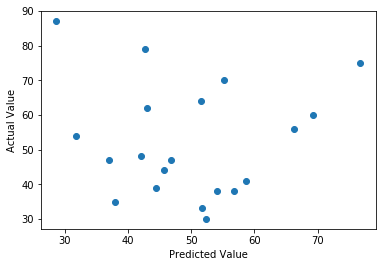

In [56]:
plt.scatter(lm.predict(w_stats), c.Points)
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
#plplt.title("Relationship between CRIM and Price")
plt.show()

In [57]:
train_n = train[['buildUpPlaySpeed',
 

 'buildUpPlayPassing',

 'chanceCreationPassing',

 'chanceCreationCrossing',

 'chanceCreationShooting',

 'defencePressure',

 'defenceAggression',

 'defenceTeamWidth']].copy()

w_stats_n = w_stats[['buildUpPlaySpeed',
 

 'buildUpPlayPassing',

 'chanceCreationPassing',

 'chanceCreationCrossing',

 'chanceCreationShooting',

 'defencePressure',

 'defenceAggression',

 'defenceTeamWidth']].copy()

In [58]:
lm.fit(train_n, target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [59]:
lm.predict(w_stats_n)

array([66.1079648 , 47.9454671 , 68.89437659, 61.65349859, 58.30061994,
       37.6383273 , 50.17993156, 35.80172133, 52.10572774, 47.4991384 ,
       54.42462063, 71.41409255, 54.08952252, 52.54658781, 48.55137273,
       59.16014638, 44.22080818, 53.04961325, 40.31956774, 54.47414908])

In [60]:
mean_squared_error(c.Points, lm.predict(w_stats_n))

199.68134060523113

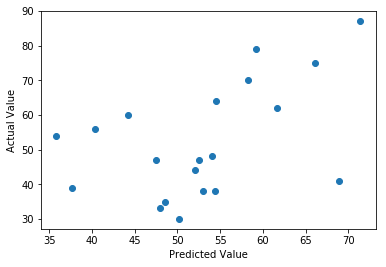

In [61]:
plt.scatter(lm.predict(w_stats_n), c.Points)
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
#plplt.title("Relationship between CRIM and Price")
plt.show()

In [62]:
c = z.copy()
c['predict'] = lm.predict(w_stats_n)
c.sort_values(by = ['predict'], ascending = [False])

,team_api_id,team_long_name,Win,Draw,Loss,Goal_Scored,Goal_Conceded,Goal_Differential,Points,predict
11,8455,Chelsea,26,9,3,73,32,41,87,71.414093
2,8197,Leicester City,11,8,19,46,55,-9,41,68.894377
0,9825,Arsenal,22,9,7,71,36,35,75,66.107965
3,8650,Liverpool,18,8,12,52,48,4,62,61.653499
15,8456,Manchester City,24,7,7,83,38,45,79,59.160146
4,10260,Manchester United,20,10,8,62,37,25,70,58.300620
19,8586,Tottenham Hotspur,19,7,12,58,53,5,64,54.474149
10,10252,Aston Villa,10,8,20,31,57,-26,38,54.424621
12,9826,Crystal Palace,13,9,16,47,51,-4,48,54.089523
17,8472,Sunderland,7,17,14,31,53,-22,38,53.049613
